# Imports

In [2]:
import json
import random
from datetime import datetime, timedelta
from typing import List, Dict, Tuple

# Helper Functions Definitions

In [3]:

# Function to simulate random names for jobs
def generate_random_name():
    names = ["Inspection", "Repair", "Maintenance", "Installation", "Survey", "Configuration"]
    return random.choice(names)

import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import textwrap

# Function to create a table for job assignments with enhanced labels
def visualize_job_assignments(job_schedule, resources, date_range, jobs, title):
    start_date = datetime.strptime(date_range["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(date_range["end_date"], "%Y-%m-%d")
    dates = pd.date_range(start=start_date, end=end_date)

    # Initialize empty table with resources (rows) and dates (columns)
    table_data = pd.DataFrame("", index=[res["id"] for res in resources], columns=dates.date)
    resource_skills = {res["id"]: ", ".join(res["skills"]) for res in resources}  # Map resource ID to skills
    job_skills = {job["id"]: ", ".join(job["required_skills"]) for job in jobs}  # Map job ID to skills

    # Populate the table with job assignments and required skills
    for event, assignment in job_schedule:
        resource_id = assignment["resource_id"]
        job_date = datetime.strptime(event["start_date"], "%Y-%m-%d").date()
        job_id = event["job_id"]
        if job_date in table_data.columns:
            wrapped_skills = textwrap.fill(f"{job_id} ({job_skills[job_id]})", width=10)
            table_data.at[resource_id, job_date] = wrapped_skills

    # Plot the table
    fig, ax = plt.subplots(figsize=(len(dates)+4, len(resources)+4))  # Increased figure size
    ax.axis("off")  # Turn off the default axis
    ax.set_title(f"Job Assignments with Resource and Job Skills - {title}", fontsize=14, weight="bold")

    # Define color formatting
    cell_colors = []
    for res_id in table_data.index:
        row_colors = []
        for date in table_data.columns:
            if table_data.at[res_id, date] == "":
                row_colors.append("beige")
            else:
                row_colors.append("lightblue")
        cell_colors.append(row_colors)

    # Update row labels to include resource skills
    row_labels = [f"{res_id}\n({textwrap.fill(resource_skills[res_id], width=10)})" for res_id in table_data.index]

    # Ensure table_data columns are a DatetimeIndex
    table_data.columns = pd.to_datetime(table_data.columns)
    
    # Create the table
    table = ax.table(
        cellText=table_data.values,
        rowLabels=row_labels,
        colLabels=[date.strftime("%Y-%m-%d") for date in table_data.columns],
        cellColours=cell_colors,
        loc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.auto_set_column_width(col=list(range(len(table_data.columns))))

    # Adjust row heights and column widths
    for (i, j), cell in table.get_celld().items():
        cell.set_height(0.08)  # Adjust row height
        cell.set_width(0.1)    # Adjust column width

    plt.show()


In [4]:
def find_unassigned_jobs(input_data: Dict, job_schedule: List[Tuple[Dict, Dict]]) -> List[Dict]:
    """
    Identify unassigned jobs by comparing input jobs with the scheduled jobs.
    
    Parameters:
    - input_data (Dict): The input data containing all jobs.
    - job_schedule (List[Tuple[Dict, Dict]]): The list of scheduled jobs.

    Returns:
    - List[Dict]: A list of unassigned job dictionaries.
    """
    # Extract all job IDs from input data
    all_jobs = {job["id"]: job for job in input_data["jobs"]}
    
    # Extract scheduled job IDs from the job schedule
    scheduled_job_ids = {event["job_id"] for event, _ in job_schedule}
    
    # Find unassigned jobs: jobs not in the scheduled_job_ids
    unassigned_jobs = [job for job_id, job in all_jobs.items() if job_id not in scheduled_job_ids]
    
    return unassigned_jobs

In [18]:
import json

def export_job_schedule_to_json(job_schedule: List[Tuple[Dict, Dict]], filename: str):
    """
    Export the job schedule to a JSON file.
    
    Parameters:
    - job_schedule (List[Tuple[Dict, Dict]]): The list containing job events and assignments.
    - filename (str): The name of the output JSON file.
    """
    # Prepare data in a structured format
    export_data = []
    for event, assignment in job_schedule:
        export_data.append({
            "event": {
                "name": event["name"],
                "job_id": event["job_id"],
                "start_date": event["start_date"],
                "end_date": event["end_date"],
                "start_time": event.get("start_time"),
                "end_time": event.get("end_time"),
            },
            "event_assignment": {
                "id": assignment.get("id"),
                "event_id": assignment.get("event_id"),
                "resource_id": assignment["resource_id"],
                "key": assignment.get("key"),
            }
        })
    
    # Write to a JSON file
    with open(filename, "w") as json_file:
        json.dump(export_data, json_file, indent=4)
    
    print(f"Job schedule exported successfully to {filename}")

# Generate Input Data

In [5]:
random.seed(42)

# 25 jobs and 5 resource
input_data = {
    "job_ids": [f"job_{i+1}" for i in range(25)],  # 25 jobs
    "resource_ids": [f"res_{i+1}" for i in range(5)],  # 5 resources
    "date_range": {"start_date": "2024-06-01", "end_date": "2024-06-05"},  # Extended date range
    "resources": [
        {"id": "res_1", "skills": ["electric", "inspection"]},
        {"id": "res_2", "skills": ["repair", "installation"]},
        {"id": "res_3", "skills": ["electric", "repair"]},
        {"id": "res_4", "skills": ["inspection", "maintenance"]},
        {"id": "res_5", "skills": ["installation", "survey"]},
    ],
    "jobs": [
        {"id": f"job_{i+1}", "required_skills": random.choice([
            ["electric"], ["repair"], ["inspection"], ["installation"], 
            ["maintenance"], ["survey"], ["electric", "repair"]
        ])} for i in range(25)
    ]
}

# V0 - Round Robin + Skill Matching

1. Initialization:
	- Maintain a pointer (or index) for each group of resources that share the same skill set. This ensures that resources are selected fairly in a round-robin manner.
	- Track each resource’s next available date for job assignments.


2. Job Assignment:
	- For each job:
		1. Identify all eligible resources (resources that have the required skills).
		2. Retrieve the round-robin pointer for the job’s skill group to identify the next resource to assign.
		3. Assign the job to the selected resource on its next available date.
		4. Update:
			- The resource’s next available date (increment by 1 day).
			- The round-robin pointer to the next resource in the cycle.


3. Skill Grouping:
	- Resources are grouped based on their skill sets.
	- Jobs are assigned to resources within the relevant skill group, cycling through the resources in a round-robin order.

In [6]:
import random
from datetime import datetime, timedelta
from typing import Dict, List, Tuple

def true_round_robin_auto_schedule(data: Dict) -> List[Tuple[Dict, Dict]]:
    job_ids = data["job_ids"]
    resources = data["resources"]
    jobs = data["jobs"]
    start_date = datetime.strptime(data["date_range"]["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(data["date_range"]["end_date"], "%Y-%m-%d")

    # Initialize availability for each resource
    resource_availability = {res["id"]: start_date for res in resources}

    # Keep track of where we are in the round-robin cycle for each skill group
    round_robin_pointers = {}

    # Job schedule output
    job_schedule = []

    # Helper function to filter resources based on job skills
    def get_eligible_resources(required_skills):
        return [res for res in resources if set(required_skills).issubset(res["skills"])]

    # Process jobs one by one
    for job in jobs:
        job_id = job["id"]
        required_skills = job["required_skills"]

        # Find all eligible resources
        eligible_resources = get_eligible_resources(required_skills)
        if not eligible_resources:
            print(f"Warning: No resources available for job {job_id}.")
            continue

        # Initialize round-robin pointer for this skill group if not already initialized
        skill_key = "_".join(sorted(required_skills))  # Unique key for this skill group
        if skill_key not in round_robin_pointers:
            round_robin_pointers[skill_key] = 0

        # Find the next eligible resource in round-robin order
        num_resources = len(eligible_resources)
        start_index = round_robin_pointers[skill_key]
        chosen_resource = None
        for i in range(num_resources):
            index = (start_index + i) % num_resources  # Cycle through resources
            resource = eligible_resources[index]
            if resource_availability[resource["id"]] <= end_date:
                chosen_resource = resource
                round_robin_pointers[skill_key] = (index + 1) % num_resources  # Update pointer
                break

        if not chosen_resource:
            print(f"Warning: No available resources for job {job_id} within the date range.")
            continue

        # Assign the job to the chosen resource
        resource_id = chosen_resource["id"]
        job_date = resource_availability[resource_id]

        # Create "event" and "event_assignment"
        event = {
            "name": f"Job {job_id}",
            "job_id": job_id,
            "start_date": job_date.strftime("%Y-%m-%d"),
            "end_date": job_date.strftime("%Y-%m-%d"),
            "start_time": None,
            "end_time": None
        }
        event_assignment = {
            "id": None,
            "event_id": None,
            "resource_id": resource_id,
            "key": None
        }

        # Append to the schedule
        job_schedule.append((event, event_assignment))

        # Update resource availability to the next day
        resource_availability[resource_id] += timedelta(days=1)

    return job_schedule

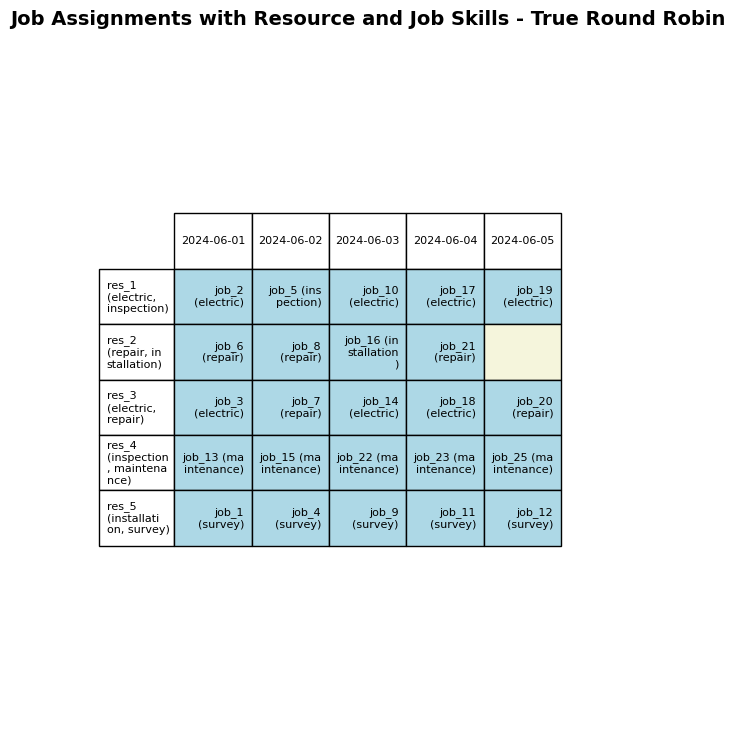

In [7]:
# Generate job schedule using the updated input_data
job_schedule = true_round_robin_auto_schedule(input_data)

# Visualize the job assignments with resource and job skills
visualize_job_assignments(job_schedule, input_data["resources"], input_data["date_range"], input_data["jobs"], 'True Round Robin')

In [8]:
# Example usage:
# Find unassigned jobs
unassigned_jobs = find_unassigned_jobs(input_data, job_schedule)

# Print the list of unassigned jobs
print("Unassigned Jobs:")
for job in unassigned_jobs:
    print(f"Job ID: {job['id']}, Required Skills: {job['required_skills']}")

Unassigned Jobs:
Job ID: job_24, Required Skills: ['electric']


# V1 - Greedy Scheduling with Skills Matching

For each job, 
1. Identify the resources that:
	- Have the required skills for the job.
	- Are available on their calendar within the scheduling window.
2. Among the eligible resources, assign the job to the one with the most availability (the resource with the most “free days” left in their calendar).
3. If multiple resources are tied for availability, break ties randomly.

In [9]:
import random
from datetime import datetime, timedelta
from typing import Dict, List, Tuple

def greedy_auto_schedule(data: Dict) -> List[Tuple[Dict, Dict]]:
    job_ids = data["job_ids"]
    resources = data["resources"]
    jobs = data["jobs"]
    start_date = datetime.strptime(data["date_range"]["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(data["date_range"]["end_date"], "%Y-%m-%d")

    # Initialize resource availability: track next free date and count of free days left
    resource_availability = {
        res["id"]: {"next_free_date": start_date, "free_days_left": (end_date - start_date).days + 1}
        for res in resources
    }

    # Prepare a map of job skills for quick lookup
    job_required_skills = {job["id"]: job["required_skills"] for job in jobs}

    # Job schedule output
    job_schedule = []

    # Function to check resource eligibility
    def is_eligible(resource, job_skills):
        return set(job_skills).issubset(resource["skills"])

    # Process each job greedily
    for job_id in job_ids:
        job_skills = job_required_skills[job_id]
        
        # Identify eligible resources
        eligible_resources = [
            res for res in resources
            if is_eligible(res, job_skills) and resource_availability[res["id"]]["free_days_left"] > 0
        ]
        
        if not eligible_resources:
            # If no eligible resources, skip this job
            print(f"Warning: No resource available for job {job_id}.")
            continue
        
        # Select the resource with the most availability (breaking ties randomly)
        eligible_resources.sort(key=lambda res: resource_availability[res["id"]]["free_days_left"], reverse=True)
        max_availability = resource_availability[eligible_resources[0]["id"]]["free_days_left"]
        tied_resources = [res for res in eligible_resources if resource_availability[res["id"]]["free_days_left"] == max_availability]
        chosen_resource = random.choice(tied_resources)
        
        # Assign job to the chosen resource
        resource_id = chosen_resource["id"]
        job_date = resource_availability[resource_id]["next_free_date"]

        # Create "event" and "event_assignment"
        event = {
            "name": f"Job {job_id}",
            "job_id": job_id,
            "start_date": job_date.strftime("%Y-%m-%d"),
            "end_date": job_date.strftime("%Y-%m-%d"),
            "start_time": None,
            "end_time": None
        }
        event_assignment = {
            "id": None,
            "event_id": None,
            "resource_id": resource_id,
            "key": None
        }

        # Append to the schedule
        job_schedule.append((event, event_assignment))

        # Update resource availability
        resource_availability[resource_id]["next_free_date"] += timedelta(days=1)
        resource_availability[resource_id]["free_days_left"] -= 1

    return job_schedule

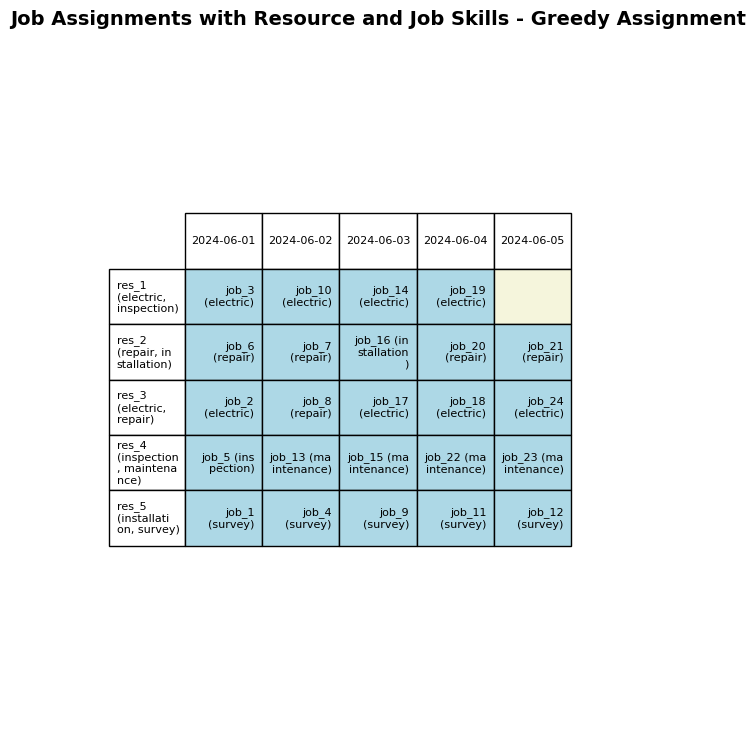

In [10]:
# Generate job schedule using the updated input_data
job_schedule = greedy_auto_schedule(input_data)

# Visualize the job assignments with resource and job skills
visualize_job_assignments(job_schedule, input_data["resources"], input_data["date_range"], input_data["jobs"], 'Greedy Assignment')

In [11]:
# Example usage:
# Find unassigned jobs
unassigned_jobs = find_unassigned_jobs(input_data, job_schedule)

# Print the list of unassigned jobs
print("Unassigned Jobs:")
for job in unassigned_jobs:
    print(f"Job ID: {job['id']}, Required Skills: {job['required_skills']}")

Unassigned Jobs:
Job ID: job_25, Required Skills: ['maintenance']


# V2 - Schedule Optimization + Skill Matching
## Optimizing for Resource Coverage

The problem can be formulated as follows:
-	Objective: Maximize the number of assigned jobs.
-	Variables: A binary variable x[j, r, d] for each job-resource-day combination (1 if job j is assigned to resource r on day d, otherwise 0).
-	Constraints:
1.	Each job must be assigned at most once.
2.	A resource can only handle one job per day.
3.	Skill matching between resources and jobs.

Integer Linear Programming (ILP) is an improvement on previous approaches because:
-	It guarantees an optimal solution if solvable.
-	It allows you to prioritize maximized job assignments while respecting constraints.

### Using Pulp Package

In [12]:
import pulp
from datetime import datetime, timedelta

def ilp_auto_schedule(data):
    job_ids = data["job_ids"]
    resources = data["resources"]
    jobs = data["jobs"]
    start_date = datetime.strptime(data["date_range"]["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(data["date_range"]["end_date"], "%Y-%m-%d")

    # Generate all dates in the date range
    dates = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end_date - start_date).days + 1)]

    # Create the LP problem
    prob = pulp.LpProblem("JobScheduling", pulp.LpMaximize)

    # Decision variables: x[job, resource, date] = 1 if job is assigned to resource on a date
    x = pulp.LpVariable.dicts("assign", ((job["id"], res["id"], date) for job in jobs for res in resources for date in dates), 
                              cat="Binary")

    # Objective: Maximize the number of scheduled jobs
    prob += pulp.lpSum(x[job["id"], res["id"], date] for job in jobs for res in resources for date in dates)

    # Constraint 1: Each job is assigned at most once
    for job in jobs:
        prob += pulp.lpSum(x[job["id"], res["id"], date] for res in resources for date in dates) <= 1

    # Constraint 2: A resource can only handle one job per day
    for res in resources:
        for date in dates:
            prob += pulp.lpSum(x[job["id"], res["id"], date] for job in jobs) <= 1

    # Constraint 3: Skill matching - A resource must have the skills required for a job
    for job in jobs:
        required_skills = set(job["required_skills"])
        for res in resources:
            if not required_skills.issubset(set(res["skills"])):
                for date in dates:
                    x[job["id"], res["id"], date].upBound = 0  # Force to 0 if skills don't match

    # Solve the problem
    prob.solve()

    # Extract the solution
    job_schedule = []
    for job in jobs:
        for res in resources:
            for date in dates:
                if pulp.value(x[job["id"], res["id"], date]) == 1:
                    event = {
                        "name": f"Job {job['id']}",
                        "job_id": job["id"],
                        "start_date": date,
                        "end_date": date,
                        "start_time": None,
                        "end_time": None
                    }
                    event_assignment = {
                        "id": None,
                        "event_id": None,
                        "resource_id": res["id"],
                        "key": None
                    }
                    job_schedule.append((event, event_assignment))
    return job_schedule



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/autoscheduler/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w3/ltdxpv4s0lx3qxyhy76z8ybr0000gp/T/a71d258f57f54830b79736e440533e80-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/w3/ltdxpv4s0lx3qxyhy76z8ybr0000gp/T/a71d258f57f54830b79736e440533e80-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 55 COLUMNS
At line 3181 RHS
At line 3232 BOUNDS
At line 3858 ENDATA
Problem MODEL has 50 rows, 625 columns and 1250 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 25 - 0.00 seconds
Cgl0004I processed model has 50 rows, 200 columns (200 integer (200 of which binary)) and 400 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -25
Cbc003

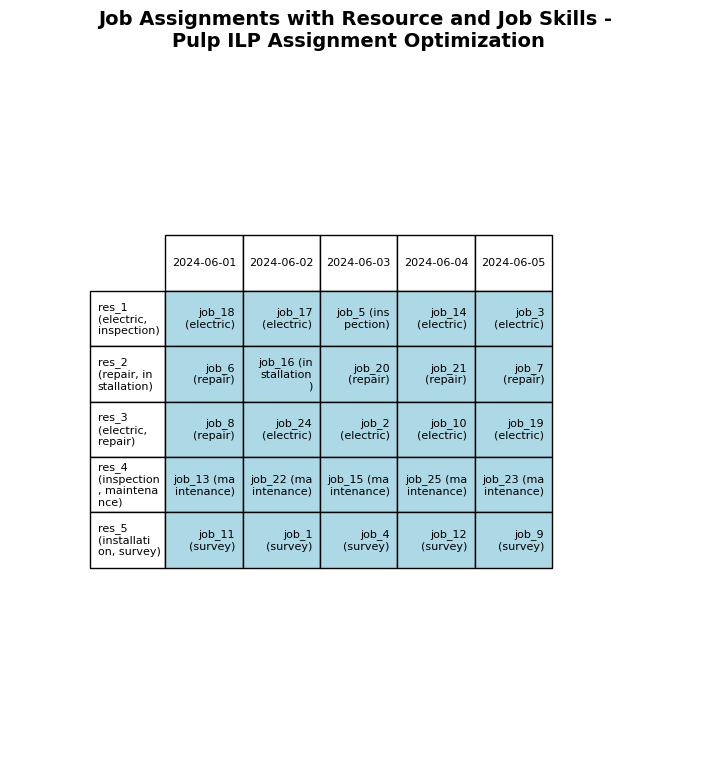

In [13]:
# Generate job schedule using the updated input_data
job_schedule = ilp_auto_schedule(input_data)

# Visualize the job assignments with resource and job skills
visualize_job_assignments(job_schedule, input_data["resources"], input_data["date_range"], input_data["jobs"], '\nPulp ILP Assignment Optimization')

### Use OR-Tools Package

In [14]:
from ortools.linear_solver import pywraplp
from datetime import datetime, timedelta

def ortools_auto_schedule(data):
    job_ids = data["job_ids"]
    resources = data["resources"]
    jobs = data["jobs"]
    start_date = datetime.strptime(data["date_range"]["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(data["date_range"]["end_date"], "%Y-%m-%d")
    
    # Generate all dates in the date range
    dates = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end_date - start_date).days + 1)]
    
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        print("Solver unavailable.")
        return []
    
    # Decision variables: x[j, r, d] = 1 if job j is assigned to resource r on day d
    x = {}
    for job in jobs:
        for res in resources:
            for date in dates:
                x[job["id"], res["id"], date] = solver.BoolVar(f'x_{job["id"]}_{res["id"]}_{date}')
    
    # Objective: Maximize the number of scheduled jobs
    solver.Maximize(solver.Sum(x[job["id"], res["id"], date] for job in jobs for res in resources for date in dates))
    
    # Constraint 1: Each job is assigned at most once
    for job in jobs:
        solver.Add(solver.Sum(x[job["id"], res["id"], date] for res in resources for date in dates) <= 1)
    
    # Constraint 2: Each resource can only handle one job per day
    for res in resources:
        for date in dates:
            solver.Add(solver.Sum(x[job["id"], res["id"], date] for job in jobs) <= 1)
    
    # Constraint 3: Skill matching - resource must have all required skills for the job
    for job in jobs:
        required_skills = set(job["required_skills"])
        for res in resources:
            if not required_skills.issubset(set(res["skills"])):
                for date in dates:
                    solver.Add(x[job["id"], res["id"], date] == 0)

    # Solve the problem
    status = solver.Solve()
    
    # Extract the solution
    job_schedule = []
    if status == pywraplp.Solver.OPTIMAL:
        print(f"Optimal solution found with {int(solver.Objective().Value())} jobs scheduled.")
        for job in jobs:
            for res in resources:
                for date in dates:
                    if x[job["id"], res["id"], date].solution_value() == 1:
                        event = {
                            "name": f"Job {job['id']}",
                            "job_id": job["id"],
                            "start_date": date,
                            "end_date": date,
                            "start_time": None,
                            "end_time": None
                        }
                        event_assignment = {
                            "id": None,
                            "event_id": None,
                            "resource_id": res["id"],
                            "key": None
                        }
                        job_schedule.append((event, event_assignment))
    else:
        print("No optimal solution found.")

    return job_schedule


Optimal solution found with 25 jobs scheduled.


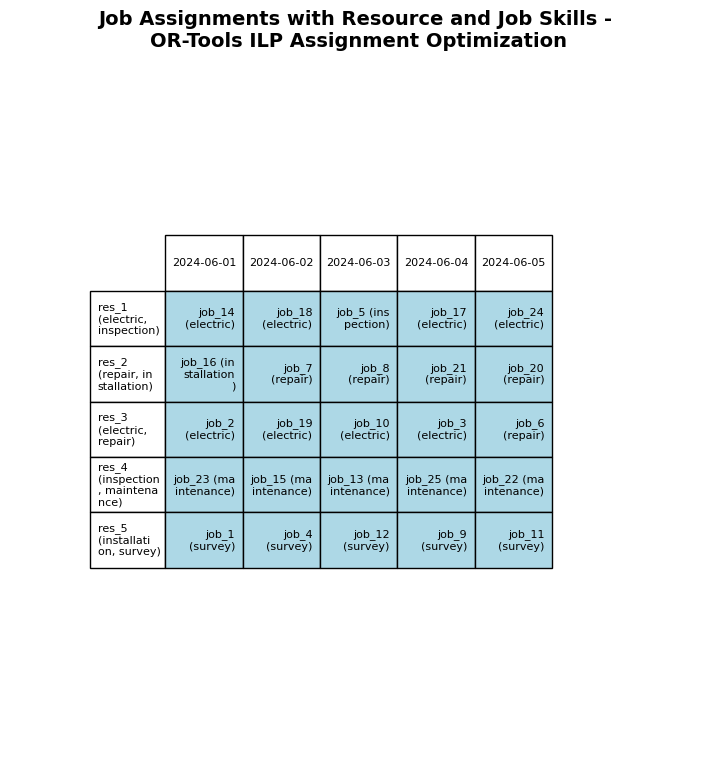

In [15]:

# Example usage
job_schedule = ortools_auto_schedule(input_data)

# Visualize the job assignments with resource and job skills
visualize_job_assignments(job_schedule, input_data["resources"], input_data["date_range"], input_data["jobs"], '\nOR-Tools ILP Assignment Optimization')

In [19]:
# Example usage
export_job_schedule_to_json(job_schedule, "or-tools-job-schedule-output.json")

Job schedule exported successfully to or-tools-job-schedule-output.json
